<a href="https://colab.research.google.com/github/claredavies/Image3DCoursework/blob/main/GLCM/GLCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [360]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.feature import greycomatrix, greycoprops
from skimage import data

from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
import pandas as pd

In [95]:
!pip install python-mnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [96]:
import fm.utils.mnist_reader as mnist_reader

# GLCM Functions

In [156]:
def showImagePatch(patch):
  plt.imshow(patch, cmap=plt.cm.gray, vmin=0, vmax=255)

In [157]:
def getPatchFromLocation(image, loc):
  patch = image[loc[0]:loc[0] + PATCH_SIZE, loc[1]:loc[1] + PATCH_SIZE]
  return patch

In [243]:
# compute some GLCM properties each patch
def calGLCMPropertiesMultiClass(class1Patches, class2Patches):
  dissimilarity = []
  correlation = []
  for patch in (class1Patches + class2Patches):
      glcm = greycomatrix(patch, 
                          distances=[5],
                          angles=[0], # We ignore this
                          levels=256, # Number of possible pixel values
                          symmetric=True, 
                          normed=True)
      dissimilarity.append(greycoprops(glcm, 'dissimilarity')[0, 0])
      correlation.append(greycoprops(glcm, 'correlation')[0, 0])
  return [dissimilarity, correlation, glcm]

In [247]:
# compute some GLCM properties each patch
def calGLCMProperties(patches):
  dissimilarity = []
  correlation = []
  for patch in (patches):
      glcm = greycomatrix(patch, 
                          distances=[5],
                          angles=[0], # We ignore this
                          levels=256, # Number of possible pixel values
                          symmetric=True, 
                          normed=True)
      dissimilarity.append(greycoprops(glcm, 'dissimilarity')[0, 0])
      correlation.append(greycoprops(glcm, 'correlation')[0, 0])
  return [dissimilarity, correlation, glcm]

In [253]:
def visualiseSelectedPatchesAndComputedFeatures(image, dissimilarity, correlation, PATCH_SIZE, patches):
  # create the figure
  fig = plt.figure(figsize=(8, 8))

  # display original image with locations of patches
  ax = fig.add_subplot(3, 2, 1)
  ax.imshow(image, cmap=plt.cm.gray, vmin=0, vmax=255)
  for (y, x) in grass_locations:
      ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')

  for (y, x) in sky_locations:
      ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')

  ax.set_xlabel('Original Image')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.axis('image')

  # for each patch, plot (dissimilarity, correlation)
  ax = fig.add_subplot(3, 2, 2)
  ax.plot(dissimilarity[:len(patches)], correlation[:len(patches)], 'go', label='Grass')
  ax.plot(dissimilarity[len(patches):], correlation[len(patches):], 'bo', label='Sky')
  ax.set_xlabel('GLCM Dissimilarity')
  ax.set_ylabel('GLCM Correlation')
  ax.legend()

  # display the image patches
  for i, patch in enumerate(patches):
      ax = fig.add_subplot(3, len(patches), len(patches)*1 + i + 1)
      ax.imshow(patch, cmap=plt.cm.gray, vmin=0, vmax=255)
      ax.set_xlabel('Grass %d' % (i + 1))

  # display the patches and plot
  fig.suptitle('Grey level co-occurrence matrix features', fontsize=14, y=1.05)
  plt.tight_layout()

In [248]:
def visualiseSelectedPatchesAndComputedFeaturesMultiClass(image, dissimilarity, correlation, PATCH_SIZE, class1, class2):
  # create the figure
  fig = plt.figure(figsize=(8, 8))

  # display original image with locations of patches
  ax = fig.add_subplot(3, 2, 1)
  ax.imshow(image, cmap=plt.cm.gray, vmin=0, vmax=255)
  for (y, x) in grass_locations:
      ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')

  for (y, x) in sky_locations:
      ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')

  ax.set_xlabel('Original Image')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.axis('image')

  # for each patch, plot (dissimilarity, correlation)
  ax = fig.add_subplot(3, 2, 2)
  ax.plot(dissimilarity[:len(class1)], correlation[:len(class1)], 'go', label='Grass')
  ax.plot(dissimilarity[len(class1):], correlation[len(class1):], 'bo', label='Sky')
  ax.set_xlabel('GLCM Dissimilarity')
  ax.set_ylabel('GLCM Correlation')
  ax.legend()

  # display the image patches
  for i, patch in enumerate(class1):
      ax = fig.add_subplot(3, len(class1), len(class1)*1 + i + 1)
      ax.imshow(patch, cmap=plt.cm.gray, vmin=0, vmax=255)
      ax.set_xlabel('Grass %d' % (i + 1))

  for i, patch in enumerate(class2):
      ax = fig.add_subplot(3, len(class2), len(class2)*2 + i + 1)
      ax.imshow(patch, cmap=plt.cm.gray, vmin=0, vmax=255)
      ax.set_xlabel('Sky %d' % (i + 1))

  # display the patches and plot
  fig.suptitle('Grey level co-occurrence matrix features', fontsize=14, y=1.05)
  plt.tight_layout()

# Dataset 1

## Read images

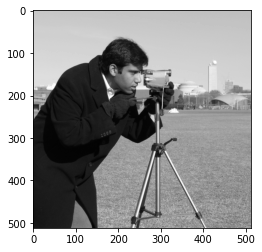

In [194]:
# Load the sample image
imageDataset1 = data.camera()
plt.imshow(imageDataset1, cmap="gray");

## Get Patches

First, we select a set of patches from the image. We select 4 grass patches and 4 sky patches, and we register them.
Next, there is the code we to select those patches manually and we save them in two independent lists.

Remember, that a patch is an image piece. In our case we have defined it as a square of $21 \times 21$ pixels.

showImagePatch used to identify sky and grass to bulk up dataset

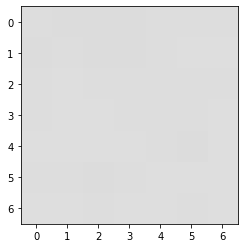

In [195]:
showImagePatch(getPatchFromLocation(imageDataset1, (150, 30)))

In [196]:
def getGrassPatches(PATCH_SIZE, image):
  grass_locations = [(280, 454), (342, 223), (444, 192), (455, 455), (340, 340), (340, 200), (370, 200), (390, 220), (400, 220)]
  grass_patches = []
  for loc in grass_locations:
      patch = getPatchFromLocation(image, loc)
      grass_patches.append(patch)
  return [grass_patches, grass_locations]

In [197]:
def getSkyPatches(PATCH_SIZE, image):
  sky_locations = [(38, 34), (139, 28), (37, 437), (145, 379), (150, 350), (150, 30), (30, 420), (150, 370), (30, 40)]
  sky_patches = []
  for loc in sky_locations:
      sky_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                              loc[1]:loc[1] + PATCH_SIZE])
  return [sky_patches, sky_locations]

In [198]:
PATCH_SIZE = 21
[grass_patches, grass_locations] = getGrassPatches(PATCH_SIZE, imageDataset1)
[sky_patches, sky_locations] = getSkyPatches(PATCH_SIZE, imageDataset1)

## Find GLCM Features

Once we have the patches selected, we can compute the GLCM features.
The computation procedure of this kind of features consists in two steps:
1. Compute the Grey Level Co-occurrence Matrix (la GLCM).
2. Compute the texture properties of the GLCM.

The first step is achieved applying the function [greycomatrix](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.graycomatrix) and the second one using [greycoprops](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.graycoprops).

In [244]:
[dissimilarity, correlation, glcm] = calGLCMPropertiesMultiClass(grass_patches, sky_patches)

In [166]:
glcm.shape

(256, 256, 1, 1)

xs - dissimilarity

In [167]:
dissimilarity

[6.044642857142856,
 11.973214285714285,
 18.794642857142858,
 18.80059523809523,
 12.214285714285714,
 11.9375,
 14.946428571428573,
 15.44642857142857,
 15.613095238095239,
 0.46726190476190477,
 0.5744047619047619,
 0.5208333333333334,
 0.5386904761904763,
 2.1875,
 0.6160714285714286,
 0.4047619047619049,
 1.3571428571428572,
 0.43154761904761907]

ys - correlation

In [168]:
correlation

[0.18465981611100118,
 0.09819326975998054,
 0.012329737526846562,
 0.03211156902114874,
 0.003840311844660029,
 -0.05085218911772683,
 0.10615735972737371,
 0.08440710798145946,
 0.09599346158167409,
 0.6499750949948057,
 0.7303979048396345,
 0.7674139951474309,
 0.5151595753523491,
 0.5974132211669424,
 0.17189467175008782,
 0.7224637764291533,
 0.6399610481586401,
 0.9225927039450565]

Next, we can visualise the selected patches and the computed features.

<ipython-input-248-c08e5265f92c>:40: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


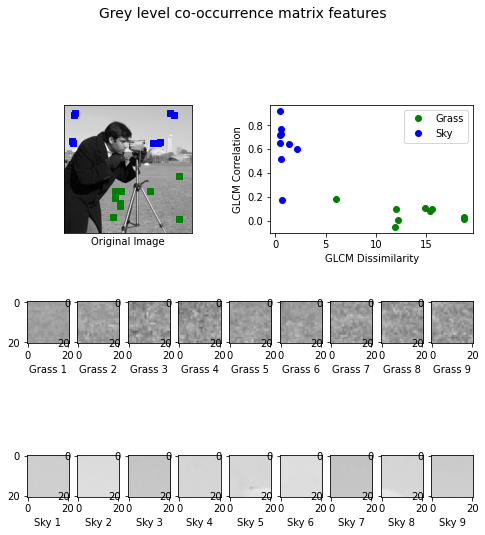

In [250]:
visualiseSelectedPatchesAndComputedFeaturesMultiClass(imageDataset1, dissimilarity, correlation, PATCH_SIZE, grass_patches, sky_patches)

## Classifier

In [ ]:
## Classifier

# Dataset *2*

## Download dataset

In [321]:
!git clone https://github.com/zalandoresearch/fashion-mnist.git fm

fatal: destination path 'fm' already exists and is not an empty directory.


In [389]:
X_train, y_train = mnist_reader.load_mnist('fm/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('fm/data/fashion', kind='t10k')

In [388]:
X_train.shape

(28, 28)

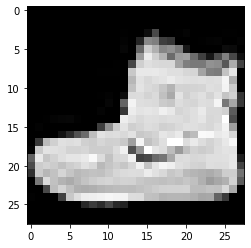

In [390]:
X_train = X_train[0].reshape((28, 28))
plt.imshow(X_train, cmap="gray")

## Feature extraction

### Training Data

In [349]:
PATCH_SIZE = int(28 / 4)
PATCH_SIZE

7

In [374]:
def getWantedSizedPatches(image, patchSize):
  patches = []
  for y in range(0, image.shape[0] - patchSize + 1, patchSize):
      for x in range(0, image.shape[1] - patchSize + 1, patchSize):
          patches.append(image[y:y + patchSize, x:x + patchSize])
  return patches

In [394]:
patchesXTrain = getWantedSizedPatches(X_train, PATCH_SIZE)

In [395]:
patchesXTrain[0].shape

(7, 7)

In [392]:
def showPatches(patches):
  fig, axes = plt.subplots(4, 4)
  axes = axes.flatten()

  for i, patch in enumerate(patches):
      axes[i].imshow(patch)
      axes[i].set_xlabel('Number %d' % (i + 1))


  plt.show()

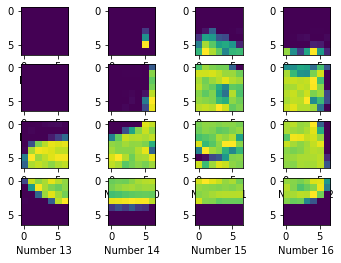

In [396]:
showPatches(patchesXTrain)

In [379]:
[dissimilarity, correlation, glcm] = calGLCMProperties(patchesXTrain)

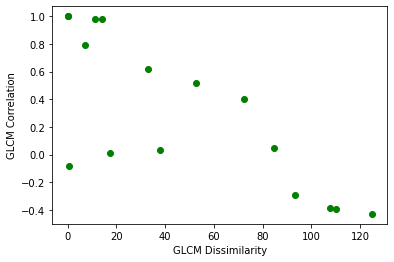

In [380]:
# for each patch, plot (dissimilarity, correlation)
plt.plot(dissimilarity[:len(patchesXTrain)], correlation[:len(patchesXTrain)], 'go')
plt.xlabel('GLCM Dissimilarity')
plt.ylabel('GLCM Correlation')
plt.show()

In [356]:
PATCH_PER_IMAGE = int(28 / PATCH_SIZE) * int(28 / PATCH_SIZE)
PATCH_PER_IMAGE

16

In [401]:
y_train = [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  
# Calling DataFrame constructor after zipping
# both lists, with columns specified
X_train = pd.DataFrame(list(zip(dissimilarity, correlation)),
               columns =['dissimilarity', 'correlation'])

### Test Data

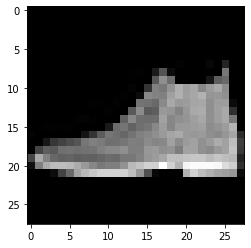

In [391]:
X_test= X_test[0].reshape((28, 28))
plt.imshow(X_test, cmap="gray")

In [397]:
patchesXTest = getWantedSizedPatches(X_test, PATCH_SIZE)

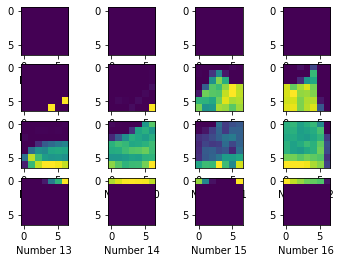

In [398]:
showPatches(patchesXTest)

In [399]:
y_test = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
  
# Calling DataFrame constructor after zipping
# both lists, with columns specified
X_test = pd.DataFrame(list(zip(dissimilarity, correlation)),
               columns =['dissimilarity', 'correlation'])

## Tasks

Build your own classifier and extract metrics to know how the classifier is working.

Detect with which classes is the classifier working better and worse. Try to explain the reasons.


**HINT:** The confusion matrix can be very helpful.

Useful link: https://towardsdatascience.com/multi-class-classification-extracting-performance-metrics-from-the-confusion-matrix-b379b427a872


In [402]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

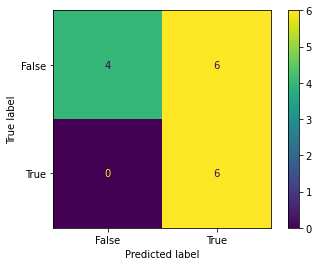

In [403]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

predicted = clf.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

# Features library

https://github.com/explainingAI/uib_vfeatures


https://pypi.org/project/uib-vfeatures/